# Experiment - Generative Pre Trained Transformers (GPT's) for OCR 

## Dataset folder structure


```
SROIE2019/
|
├── layoutlm-base-uncased/
|   |
|   ├── config.json
|   ├── pytorch_model.bin
|   ├── special_tokens_map.json
|   ├── tokenizer_config.json
|   ├── training_args.bin
|   └── vocab.txt
|
├── test/
|   ├── box/
|   |   ├── X51005230657.txt
|   |   .
|   |   .
|   |   .
|   ├── entities/
|   |   ├──X00016469670.txt
|   |   .
|   |   .  
|   |   .
|   └── img/
|       ├── X00016469670.jpg   
|       .
|       .
|       .
└── train/
    ├── box/
    |   ├── X00016469612.txt
    |   .
    |   .
    |   .
    ├── entities/
    |   ├── X00016469612.txt
    |   .
    |   .  
    |   .
    └── img/
        ├── X00016469612.jpg
        .
        .
        .
```

## Libraries

In [23]:
! pip install -q transformers
! pip install -q sentencepiece

^C


In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from tqdm.auto import tqdm
from urllib.request import urlretrieve
from zipfile import ZipFile

import numpy as np
import matplotlib as plt
import torch
import os
import glob
import pytesseract


In [ ]:
import torch
# Check the PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Check if CUDA is available
print(f"CUDA available: {torch.cuda.is_available()}")

print(torch.version.cuda)

PyTorch version: 2.3.0
CUDA available: False
None


In [ ]:
print(torch.cuda.is_available())

False


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

## LayoutLMv3 Fine Tuning

Goal: Model should output json format similar to SROIE ground truth labels: 

```
{
    "company" : "COMPANY_NAME",
    "date" : "DATE",
    'address" : "ADDRESS",
    "total" : "TOTAL",
}


Making sure have all libraries needed

In [ ]:
%%capture
! pip install datasets 
! pip install evaluate
! pip install seqeval
! pip install transformers[torch]
import warnings
warnings.filterwarnings("ignore")
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [ ]:
import os

train_path = r'C:\Users\Lenovo\Documents\GitHub\Elec376_F24_group7\backend\ml\data\SROIE2019\train'
test_path = r'C:\Users\Lenovo\Documents\GitHub\Elec376_F24_group7\backend\ml\data\unprocessed\SROIE2019\test'


len(os.listdir(train_path + '\img')), len(os.listdir(test_path + '\img'))  

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\Lenovo\\Documents\\GitHub\\Elec376_F24_group7\\backend\\ml\\data\\SROIE2019\\train\\img'

### Data Collection

collect labels

In [ ]:
labels_list = ['O', 'B-COMPANY', 'B-DATE', 'B-ADDRESS', 'B-TOTAL']
ids2label = {k: v for k, v in enumerate(labels_list)}
labels2ids = {v: k for k, v in enumerate(labels_list)}

map each bounding box to corresponding label. Data does not always match, use SequenceMatcher to verify

In [ ]:
from difflib import SequenceMatcher

def get_word_tag(word, entities):
    for entity in entities:
        if SequenceMatcher(None, word.lower(), entities[entity].lower()).ratio() >= 0.8:
            return labels2ids[f'B-{entity}']
        elif entity in ['ADDRESS', 'COMPANY'] and word.lower() in entities[entity].lower():
            return labels2ids[f'B-{entity}']
        elif entity in ['DATE', 'TOTAL'] and entities[entity].lower() in word.lower():
            return labels2ids[f'B-{entity}']
    return labels2ids['O']

def get_normalized_bbox(line, img_width, img_height):
    line = line.strip().split(',')
    x1, y1, x2, y2 = int(line[0]), int(line[1]), int(line[6]), int(line[7])
    return [x1 / img_width * 1000, y1 / img_height * 1000, x2 / img_width * 1000, y2 / img_height * 1000]

def get_word(line):
    line = line.strip().split(',')
    return ','.join(line[8:])

In [ ]:
import json

def get_entities_dict(entities_file_path):
    entities_file = open(entities_file_path, 'r')
    entities = json.load(entities_file)
    entities_file.close()
    res_dict={
        'COMPANY' : entities.get('company', ''),
        'DATE' : entities.get('date', ''),
        'ADDRESS' : entities.get('address', ''),
        'TOTAL' : entities.get('total', '')
    }
    return res_dict

In [ ]:
from PIL import Image
import pandas as pd
from pathlib import Path

def get_image_dimensions(img_path):
    img = Image.open(img_path)
    return img.size

def create_df(data_dir):
    box_path = os.path.join(data_dir, 'box')
    img_path = os.path.join(data_dir, 'img')
    entities_path = os.path.join(data_dir, 'entities')

    image_path_list = []
    bboxes_list = []
    words_list = []
    ner_tags_list = []

    for file in os.listdir(img_path):
        id = Path(file).stem

        box_file_path = os.path.join(box_path, f'{id}.txt')
        entities_file_path = os.path.join(entities_path, f'{id}.txt')

        img_width, img_height = get_image_dimensions(os.path.join(img_path, file))

        try: 
            with open(box_file_path, 'r') as f:
                lines = f.readlines()
                words = [get_word(line) for line in lines]
                bboxes = [get_normalized_bbox(line, img_width, img_height) for line in lines]

                entities = get_entities_dict(entities_file_path)
                ner_tags  = [get_word_tag(word, entities) for word in words]

                image_path_list.append(os.path.join(img_path, file))
                bboxes_list.append(bboxes)
                words_list.append(words)
                ner_tags_list.append(ner_tags)
        except:
            pass
    df = pd.DataFrame({
        'image_path' : image_path_list,
        'bboxes' : bboxes_list,
        'words' : words_list,
        'ner_tags' : ner_tags_list
    })

    return df

Create train and test dataframes 

In [ ]:
train_df = create_df(train_path)
test_df = create_df(test_path)

len(train_df), len(test_df)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\Lenovo\\Documents\\GitHub\\Elec376_F24_group7\\backend\\ml\\data\\SROIE2019\\train\\img'

In [ ]:
train_df

,image_path,bboxes,words,ner_tags
0,C:\Users\Lenovo\Documents\GitHub\Elec376_F24_g...,"[[155.5075593952484, 24.679170779861796, 155.5...","[TAN WOON YANN, BOOK TA .K(TAMAN DAYA) SDN BND...","[0, 1, 0, 3, 3, 3, 3, 0, 0, 2, 0, 0, 0, 0, 0, ..."
1,C:\Users\Lenovo\Documents\GitHub\Elec376_F24_g...,"[[173.12072892938497, 49.800796812749, 173.120...","[TAN WOON YANN, INDAH GIFT & HOME DECO, 27,JAL...","[0, 1, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, ..."
2,C:\Users\Lenovo\Documents\GitHub\Elec376_F24_g...,"[[259.25925925925924, 49.52581664910432, 259.2...","[TAN WOON YANN, MR D.T.Y. (JOHOR) SDN BHD, (CO...","[0, 1, 0, 3, 3, 3, 3, 0, 0, 0, 0, 3, 0, 0, 0, ..."
3,C:\Users\Lenovo\Documents\GitHub\Elec376_F24_g...,"[[208.24295010845987, 43.944265809217576, 208....","[TAN WOON YANN, YONGFATT ENTERPRISE, (JM051772...","[0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, ..."
4,C:\Users\Lenovo\Documents\GitHub\Elec376_F24_g...,"[[179.26565874730022, 39.96101364522417, 179.2...","[TAN WOON YANN, MR D.I.Y. (M) SDN BHD, (CO. RF...","[0, 1, 0, 3, 3, 3, 3, 0, 0, 0, 0, 3, 0, 0, 0, ..."
...,...,...,...,...
621,C:\Users\Lenovo\Documents\GitHub\Elec376_F24_g...,"[[108.17610062893083, 192.96187683284458, 108....","[ONE ONE THREE SEAFOOD RESTAURANT SDN BHD, (11...","[1, 0, 3, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, ..."
622,C:\Users\Lenovo\Documents\GitHub\Elec376_F24_g...,"[[109.70996216897856, 208.4352078239609, 109.7...","[ONE ONE THREE SEAFOOD RESTAURANT SDN BHD, (11...","[1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, ..."
623,C:\Users\Lenovo\Documents\GitHub\Elec376_F24_g...,"[[107.4589127686473, 172.87784679089026, 107.4...","[ONE ONE THREE SEAFOOD RESTAURANT SDN BHD, (11...","[1, 0, 3, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, ..."
624,C:\Users\Lenovo\Documents\GitHub\Elec376_F24_g...,"[[27.444253859348198, 30.69838833461243, 27.44...","[3180303, GL HANDICRAFT & TAIL ORING, 19, JALA...","[0, 1, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, ..."


In [ ]:
def create_stats_df(df):
  stats_not_other = df['ner_tags'].apply(lambda x: sum([1 for tag in x if tag != labels2ids['O']]))
  stats_total = df['ner_tags'].apply(lambda x: sum([1 for tag in x if tag == labels2ids['B-TOTAL']]))
  stats_address  = df['ner_tags'].apply(lambda x: sum([1 for tag in x if tag == labels2ids['B-ADDRESS']]))
  stats_company = df['ner_tags'].apply(lambda x: sum([1 for tag in x if tag == labels2ids['B-COMPANY']]))
  stats_date = df['ner_tags'].apply(lambda x: sum([1 for tag in x if tag == labels2ids['B-DATE']]))
  stats_df = pd.DataFrame({
      'total': stats_total,
      'address': stats_address,
      'company': stats_company,
      'date': stats_date,
      'not_other': stats_not_other
  })
  return stats_df

stats_df = create_stats_df(train_df)
stats_df.describe()

,total,address,company,date,not_other
count,626.000000,626.000000,626.000000,626.000000,626.000000
mean,3.107029,4.966454,1.305112,1.214058,10.592652
std,2.065267,4.195673,1.103249,0.440575,4.888374
min,1.000000,0.000000,0.000000,0.000000,2.000000
25%,2.000000,3.000000,1.000000,1.000000,8.000000
50%,3.000000,4.000000,1.000000,1.000000,9.000000
75%,4.000000,5.750000,1.000000,1.000000,12.000000
max,33.000000,25.000000,9.000000,3.000000,39.000000


Multiple Address and total bounding boxes, need a way to select only one, as we only have key value pair for each tag for our json output. 


In [ ]:
def recompute_ner_tags(row):
  ner_tags = row['ner_tags']
  bboxes = row['bboxes']
  
  new_ner_tags = [labels2ids['O'] for _ in ner_tags]
  
  # Give company tag only to the largest bounding box
  company_idx = [i for i, tag in enumerate(ner_tags) if tag == labels2ids['B-COMPANY']]
  if len(company_idx) > 0:
    max_idx = max(company_idx, key=lambda x: (bboxes[x][2] - bboxes[x][0]) * (bboxes[x][3] - bboxes[x][1]))
    new_ner_tags[max_idx] = labels2ids['B-COMPANY']
    
  # Give address tag only to the largest bounding box
  address_idx = [i for i, tag in enumerate(ner_tags) if tag == labels2ids['B-ADDRESS']]
  if len(address_idx) > 0:
    max_idx = max(address_idx, key=lambda x: (bboxes[x][2] - bboxes[x][0]) * (bboxes[x][3] - bboxes[x][1]))
    new_ner_tags[max_idx] = labels2ids['B-ADDRESS']
    
  # Give date tag to the earliest bounding box
  date_idx = [i for i, tag in enumerate(ner_tags) if tag == labels2ids['B-DATE']]
  if len(date_idx) > 0:
    min_idx = min(date_idx, key=lambda x: (bboxes[x][1] + bboxes[x][3])/2)
    new_ner_tags[min_idx] = labels2ids['B-DATE']
  
  # Give total tag to the last bounding box
  total_idx = [i for i, tag in enumerate(ner_tags) if tag == labels2ids['B-TOTAL']]
  if len(total_idx) > 0:
    max_idx = max(total_idx, key=lambda x: (bboxes[x][1] + bboxes[x][3])/2)
    new_ner_tags[max_idx] = labels2ids['B-TOTAL']
    
  return new_ner_tags

In [ ]:
train_df['ner_tags'] = train_df.apply(recompute_ner_tags, axis=1)
test_df['ner_tags'] = test_df.apply(recompute_ner_tags, axis=1)

In [ ]:
train_stats_df = create_stats_df(train_df)
train_stats_df.describe()

,total,address,company,date,not_other
count,626.0,626.000000,626.000000,626.000000,626.000000
mean,1.0,0.992013,0.880192,0.996805,3.869010
std,0.0,0.089085,0.324997,0.056478,0.342365
min,1.0,0.000000,0.000000,0.000000,2.000000
25%,1.0,1.000000,1.000000,1.000000,4.000000
50%,1.0,1.000000,1.000000,1.000000,4.000000
75%,1.0,1.000000,1.000000,1.000000,4.000000
max,1.0,1.000000,1.000000,1.000000,4.000000


In [ ]:
test_stats_df = create_stats_df(test_df)
test_stats_df.describe()

,total,address,company,date,not_other
count,345.000000,345.000000,345.000000,345.000000,345.000000
mean,0.997101,0.985507,0.881159,0.991304,3.855072
std,0.053838,0.119684,0.324071,0.092979,0.360691
min,0.000000,0.000000,0.000000,0.000000,2.000000
25%,1.000000,1.000000,1.000000,1.000000,4.000000
50%,1.000000,1.000000,1.000000,1.000000,4.000000
75%,1.000000,1.000000,1.000000,1.000000,4.000000
max,1.000000,1.000000,1.000000,1.000000,4.000000


### Data Processing

In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset, test_dataset

(Dataset({
     features: ['image_path', 'bboxes', 'words', 'ner_tags'],
     num_rows: 626
 }),
 Dataset({
     features: ['image_path', 'bboxes', 'words', 'ner_tags'],
     num_rows: 345
 }))

In [24]:
from transformers import AutoProcessor

model_id = 'microsoft/layoutlmv3-base'

processor = AutoProcessor.from_pretrained(model_id, apply_ocr=False)

In [22]:
def prepare_examples(examples):
    images = [Image.open(path).convert('RGB') for path in examples["image_path"]]
    words = examples["words"]
    bboxes = examples["bboxes"]
    ner_tags = examples["ner_tags"]
    encoding = processor(
        images,
        words,
        boxes=bboxes,
        word_labels=ner_tags,
        padding="max_length",
        truncation=True)
    return encoding

In [23]:
from datasets import Features, Sequence, Value, Array2D, Array3D

features = Features({
    'pixel_values' : Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids' : Sequence(feature=Value(dtype='int64')),
    'attention_mask' : Sequence(Value(dtype='int64')),
    'bbox' : Array2D(dtype='int64', shape=(512,4)),
    'labels' : Sequence(feature=Value(dtype='int64')),
})

In [24]:
train_dataset = train_dataset.map(
    prepare_examples,
    batched=True,
    remove_columns=train_dataset.column_names,
    batch_size=32,
    features=features)

test_dataset = test_dataset.map(
    prepare_examples,
    batched=True,
    remove_columns=test_dataset.column_names,
    batch_size=32,
    features=features)

Map:   0%|          | 0/626 [00:00<?, ? examples/s]

Map:   0%|          | 0/345 [00:00<?, ? examples/s]

In [25]:
train_dataset.save_to_disk('data/train')
test_dataset.save_to_disk('data/test')

Saving the dataset (0/1 shards):   0%|          | 0/626 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/345 [00:00<?, ? examples/s]

### Fine tuning LayoutMv3 on SROIE (receipt dataset)

Loading Dataset

In [26]:
from datasets import load_from_disk

train_dataset = load_from_disk("data/train")
test_dataset = load_from_disk("data/test")

Loading the Processor

In [57]:
from transformers import AutoProcessor

model_id = 'microsoft/layoutlmv3-base'

processors = AutoProcessor.from_pretrained(model_id)

Loading the Model

In [27]:
from transformers import AutoModelForTokenClassification

labels_list = ['O', 'B-COMPANY', 'B-DATE', 'B-ADDRESS', 'B-TOTAL']
ids2labels = {k: v for k, v in enumerate(labels_list)}
labels2ids = {v: k for k, v in enumerate(labels_list)}

model = AutoModelForTokenClassification.from_pretrained(
    model_id,
    label2id=labels2ids,
    id2label=ids2labels)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Computing Metrics

In [29]:
import numpy as np
import evaluate

seqeval = evaluate.load("seqeval")

def compute_metrics(p):
  predictions, labels = p
  predictions = np.argmax(predictions, axis=2)
  true_predictions = [
    [labels_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
  ]
  true_labels = [
    [labels_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
  ]
  results = seqeval.compute(predictions=true_predictions, references=true_labels)
  return {
      "precision": results["overall_precision"],
      "recall": results["overall_recall"],
      "f1": results["overall_f1"],
      "accuracy": results["overall_accuracy"],
  }

Training

In [30]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="checkpoints",
    num_train_epochs=3,
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    save_strategy="steps",
    eval_strategy="steps",
    report_to="none")

In [31]:
from transformers import Trainer, default_data_collator

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

In [32]:
trainer.train()

  0%|          | 0/471 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

{'eval_loss': 0.07646319270133972, 'eval_precision': 0.7893258426966292, 'eval_recall': 0.8451127819548873, 'eval_f1': 0.8162672476397965, 'eval_accuracy': 0.9727722772277227, 'eval_runtime': 621.3496, 'eval_samples_per_second': 0.555, 'eval_steps_per_second': 0.14, 'epoch': 0.64}


  0%|          | 0/87 [00:00<?, ?it/s]

{'eval_loss': 0.0579569935798645, 'eval_precision': 0.8658170914542729, 'eval_recall': 0.868421052631579, 'eval_f1': 0.8671171171171171, 'eval_accuracy': 0.9809513560051657, 'eval_runtime': 590.6077, 'eval_samples_per_second': 0.584, 'eval_steps_per_second': 0.147, 'epoch': 1.27}


  0%|          | 0/87 [00:00<?, ?it/s]

{'eval_loss': 0.050410449504852295, 'eval_precision': 0.8837719298245614, 'eval_recall': 0.9090225563909774, 'eval_f1': 0.8962194217939214, 'eval_accuracy': 0.9850408953938872, 'eval_runtime': 600.3609, 'eval_samples_per_second': 0.575, 'eval_steps_per_second': 0.145, 'epoch': 1.91}


  0%|          | 0/87 [00:00<?, ?it/s]

{'eval_loss': 0.05356764793395996, 'eval_precision': 0.8669064748201439, 'eval_recall': 0.9060150375939849, 'eval_f1': 0.8860294117647058, 'eval_accuracy': 0.9834266035299182, 'eval_runtime': 579.0752, 'eval_samples_per_second': 0.596, 'eval_steps_per_second': 0.15, 'epoch': 2.55}
{'train_runtime': 20643.9372, 'train_samples_per_second': 0.091, 'train_steps_per_second': 0.023, 'train_loss': 0.07094392553762773, 'epoch': 3.0}


TrainOutput(global_step=471, training_loss=0.07094392553762773, metrics={'train_runtime': 20643.9372, 'train_samples_per_second': 0.091, 'train_steps_per_second': 0.023, 'total_flos': 495041961535488.0, 'train_loss': 0.07094392553762773, 'epoch': 3.0})

In [33]:
trainer.evaluate()

  0%|          | 0/87 [00:00<?, ?it/s]

{'eval_loss': 0.0502050556242466,
 'eval_precision': 0.8870139398385913,
 'eval_recall': 0.9090225563909774,
 'eval_f1': 0.8978834014110657,
 'eval_accuracy': 0.9853637537666811,
 'eval_runtime': 610.9443,
 'eval_samples_per_second': 0.565,
 'eval_steps_per_second': 0.142,
 'epoch': 3.0}

In [34]:
trainer.save_model("model")

### Use model to extract receipt info

In [30]:
import torch
from collections import Counter
from transformers import AutoModelForTokenClassification

class ReceiptReader:
  def __init__(self, path_to_model="model"):
    self.model = AutoModelForTokenClassification.from_pretrained(path_to_model)
    self.model.eval()
    self.processor = AutoProcessor.from_pretrained(path_to_model, apply_ocr=True)      

  def __call__(self, image):
    encodings = self.__get_encodings(image)
    words = self.__get_words(encodings)
    bboxes = encodings.bbox[0]
    logits = self.model(**encodings).logits
    predictions = torch.argmax(logits, dim=2)
    labeled_tokens = [self.model.config.id2label[t.item()] for t in predictions[0]]
    response_dict = self.__merge_tokens(words, bboxes, labeled_tokens)
    response_dict["bboxes"] = [self.__unnormalize_bbox(bbox, image) for bbox in response_dict["bboxes"]]
    return response_dict
  
  def __get_encodings(self, image):
    return self.processor(image, return_tensors="pt")
  
  def __get_words(self, encodings):
    words = [self.processor.tokenizer.decode(input_id) for input_id in encodings.input_ids[0]]
    return words
  
  def __merge_tokens(self, words, bboxes, labels):
    new_words = []
    new_bboxes = []
    new_labels = []
    i = 0
    while i < len(words):
        token, bbox, label = words[i], bboxes[i], labels[i]
        j = i + 1
        while j < len(words) and self.__is_same_bbox(bbox, bboxes[j]):
            token += words[j]
            j += 1
        counter = Counter([labels[k] for k in range(i, j)])
        sorted_labels = sorted(counter, key=counter.get, reverse=True)
        if sorted_labels[0] == "O" and len(sorted_labels) > 1:
          label = sorted_labels[1]
        else:
          label = sorted_labels[0]
        new_words.append(token)
        new_bboxes.append(bbox)
        new_labels.append(label)
        i = j
    return {
        "words": new_words,
        "bboxes": new_bboxes,
        "labels": new_labels
    }
  
  def __is_same_bbox(self, bbox1, bbox2):
    for i in range(4):
        if abs(bbox1[i] - bbox2[i]) > 3:
            return False
    return True
  
  def __unnormalize_bbox(self, bbox, image):
    width, height = image.size
    return [bbox[0] * width / 1000, bbox[1] * height / 1000, bbox[2] * width / 1000, bbox[3] * height / 1000]

In [31]:
import PIL

img1 = "C:/Users/Lenovo/Documents/GitHub/Elec376_F24_group7/backend/ml/data/unprocessed/SROIE2019/test/img/X51005705784.jpg"
img2 = "1.jpg"

image = PIL.Image.open(img2).convert("RGB")
receipt_reader = ReceiptReader()
receipt_data = receipt_reader(image)    
len(receipt_data["words"]), len(receipt_data["bboxes"]), len(receipt_data["labels"])

(132, 132, 132)

In [32]:
from PIL import ImageDraw
class ReceiptLabeler:
  def __init__(self, path_to_model="model"):
    self.receipt_reader = ReceiptReader(path_to_model)
    self.label_colors = {
        "O": "yellow",
        "B-COMPANY": "purple",
        "B-DATE": "green",
        "B-ADDRESS": "blue",
        "B-TOTAL": "red"
    }
  
  def __call__(self, image, include_others=False, include_words=False):
    receipt_data = self.receipt_reader(image)
    
    labeled_image = image.copy()
    draw = ImageDraw.Draw(labeled_image)
    for word, bbox, label in zip(receipt_data['words'], receipt_data["bboxes"], receipt_data["labels"]):
      if include_others or label != "O":
        draw.rectangle(bbox, outline=self.label_colors[label], width=2)
        draw.text((bbox[0], bbox[1]-10), label, fill=self.label_colors[label])
        if include_words:
          draw.text((bbox[0], bbox[3]), word, fill=self.label_colors[label])
        
    return labeled_image

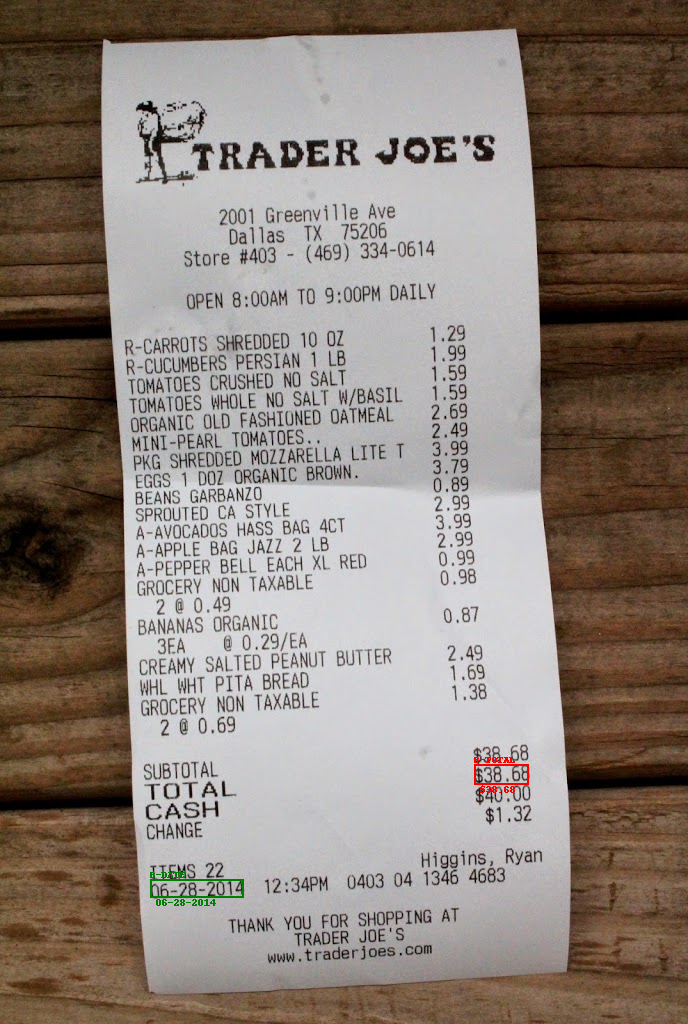

In [33]:
receipt_labeler = ReceiptLabeler()
labeled_image = receipt_labeler(image, include_words=True)
labeled_image

In [34]:
class ReceiptInformationExtractor:
  def __init__(self, path_to_model="model"):
    self.receipt_reader = ReceiptReader(path_to_model)
  
  def __call__(self, image):
    receipt_data = self.receipt_reader(image)
    response_dict = {
        "company": "",
        "date": "",
        "address": "",
        "total": ""
    }
    
    # Get the company having the largest bbox
    max_bbox = 0
    for word, bbox, label in zip(receipt_data['words'], receipt_data["bboxes"], receipt_data["labels"]):
      if label == "B-COMPANY":
        bbox_size = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
        if bbox_size > max_bbox:
          response_dict["company"] = word.strip()
          max_bbox = bbox_size
          
    # Get the address having the largest bbox
    max_bbox = 0
    for word, bbox, label in zip(receipt_data['words'], receipt_data["bboxes"], receipt_data["labels"]):
      if label == "B-ADDRESS":
        bbox_size = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
        if bbox_size > max_bbox:
          response_dict["address"] = word.strip()
          max_bbox = bbox_size
  
    # Get the topmost date
    min_y = float("inf")
    for word, bbox, label in zip(receipt_data['words'], receipt_data["bboxes"], receipt_data["labels"]):
      if label == "B-DATE" and bbox[1] < min_y:
        response_dict["date"] = word.strip()
        min_y = bbox[1]

    # Get the bottommost total
    max_y = 0
    for word, bbox, label in zip(receipt_data['words'], receipt_data["bboxes"], receipt_data["labels"]):
      if label == "B-TOTAL" and bbox[3] > max_y:
        response_dict["total"] = word.strip()
        max_y = bbox[3]
        
    return response_dict


In [35]:
receipt_info_extractor = ReceiptInformationExtractor()
receipt_info_extractor(image)

{'company': '', 'date': '06-28-2014', 'address': '', 'total': '$38.68'}

## TrOcr Fine Tuning

### Helper Functions

In [3]:
# def download_and_unzip(url, save_path):
#     print(f"Downloading and extracting assets....", end="")

#     # Downloading zip file using urllib package
#     urlretrieve(url, save_path)

#     try: 
#         # Extracting zip file using the zipfile package
#         with ZipFile(save_path) as z: 
#             # Extract ZIP file contents in the same directory
#             z.extractall(os.path.save_path[0])
        
#         print("Done")
    
#     except Exception as e:
#         print("\nInvalid file.", e)

# URL = r"https://www.dropbox.com/scl/fi/news/images.zip?rlkey=54flzvhh9xxh45czb1c8n3fp3&dl=1"
# asset_zip_path = os.path.join(os.getcwd(), "images.zip")
# # Download if assest ZIP does not exists.
# if not os.path.exists(asset_zip_path):
#     download_and_unzip(URL, asset_zip_path)



def read_image(image_path):
    """
    :param image_path : String, path to the input image.

    Returns: 
        image : PIL Image.
    """
    image = Image.open(image_path).convert("RGB")
    return image
def ocr(image, processor, model):
    """+
    :param image: PIL Image. 
    :param processor: Huggingface OCR processor.
    :param model: HUggingface OCR model

    Returns: 
        generated_text: the OCR'd text string.
    """
    # We can directly perform OCR on cropped images.
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

def eval_new_data(data_path=None, num_samples=4, model=None, processor=None):
    image_paths = glob.glob(data_path)
    for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
        if i == num_samples:
            break
        image = read_image(image_path)
        text = ocr(image, processor, model)
        plt.figure(figsize=(7,4))
        plt.imshow(image)
        plt.axis('off')
        plt.show()

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-printed')
model = VisionEncoderDecoderModel.from_pretrained(
    'microsoft/trocr-small-printed'
).to(device)


eval_new_data(
    data_path=os.path('1.jpg'),
    num_samples=1,
    model=model
)

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

c:\Users\Lenovo\anaconda3\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Lenovo\.cache\huggingface\hub\models--microsoft--trocr-small-printed. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['enc

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

AssertionError: Torch not compiled with CUDA enabled

## DTrOcr - SROIE Fine tuning

Ensure correct environment in jupyter notebook 

In [2]:
import sys 
print(sys.executable)

c:\Users\Lenovo\anaconda3\python.exe


make sure DTrOCr installation is within scope of notebooko

In [4]:
%pip install -r C:\Users\Lenovo\Documents\GitHub\Elec376_F24_group7\backend\ml\DTrOCR\requirements.txt

Note: you may need to restart the kernel to use updated packages.
  Using cached pillow-10.4.0-cp39-cp39-win_amd64.whl (2.6 MB)
  Using cached torch-2.3.1-cp39-cp39-win_amd64.whl (159.7 MB)
  Using cached transformers-4.42.4-py3-none-any.whl (9.3 MB)
  Using cached mkl-2021.4.0-py2.py3-none-win_amd64.whl (228.5 MB)
  Using cached tokenizers-0.19.1-cp39-none-win_amd64.whl (2.2 MB)
  Using cached intel_openmp-2021.4.0-py2.py3-none-win_amd64.whl (3.5 MB)
  Using cached tbb-2021.13.1-py3-none-win_amd64.whl (286 kB)
  Attempting uninstall: tbb
    Found existing installation: TBB 0.2


ERROR: Cannot uninstall 'TBB'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [ ]:
from PIL import Image
import cv2
import re
import imutils
from imutils.perspective import four_point_transform
import matplotlib.pyplot as plt

In [4]:
import sys
sys.path.append(r'C:\Users\Lenovo\Documents\GitHub\Elec376_F24_group7\backend\ml\DTrOCR')

In [6]:
from dtrocr.config import DTrOCRConfig
from dtrocr.model import DTrOCRLMHeadModel
from dtrocr.processor import DTrOCRProcessor

from PIL import Image

config = DTrOCRConfig()
model = DTrOCRLMHeadModel(config)
processor = DTrOCRProcessor(DTrOCRConfig())

model.eval()        # set model to evaluation mode for deterministic behaviour
path_to_image = "1.jpg"  # path to image file

inputs = processor(
    images=Image.open(path_to_image).convert('RGB'),
    texts=processor.tokeniser.bos_token,
    return_tensors="pt"
)


In [7]:
model_output = model.generate(
    inputs=inputs, 
    processor=processor, 
    num_beams=3,    # defaults to 1 if not specified
    use_cache=True  # defaults to True if not specified
)

predicted_text = processor.tokeniser.decode(model_output[0], skip_special_tokens=True)

In [8]:
print(predicted_text)

 BringingUnix Bringing targ targ PAN targ billed targ targ targ targ targ PAN targ targ targ targvez PAN targ targ targUnix critic targ frustrationvez ANY targvez targ targ targ targ targ targ histories billed targ targ targ critic targvez targarton targ targ targ targ targ astounding targ155 targ next targ targ targ Jennings targ targ PAN targvez PAN targ critic billed targUnix targ targvez Bringing targ histories criticvez targ targ targincinnati targ targ targ Universities compan155 targ critic targ targ targ enclosed Bringing targ enclosed targ targ targ targ collected targ targ critic targ targ targ PAN Jennings targvez PAN targ targ PAN targ targ targ targ targ targ targ enclosed targ


### Build lists of images and texts